Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NAME              2101 non-null   object 
 1   LOCATION          2101 non-null   object 
 2   TYPE              2101 non-null   object 
 3   RATING            2101 non-null   float64
 4   LOCATION_encoded  2101 non-null   int8   
 5   TYPE_encoded      2101 non-null   int16  
dtypes: float64(1), int16(1), int8(1), object(3)
memory usage: 71.9+ KB
None

Summary Statistics:
            RATING  LOCATION_encoded  TYPE_encoded
count  2101.000000       2101.000000   2101.000000
mean      4.104236          8.428367     71.186102
std       0.538115          3.788483     38.121686
min       1.000000          0.000000      0.000000
25%       3.900000          6.000000     41.000000
50%       4.100000          9.000000     69.000000
75%       4.400000         12.000000    100.0

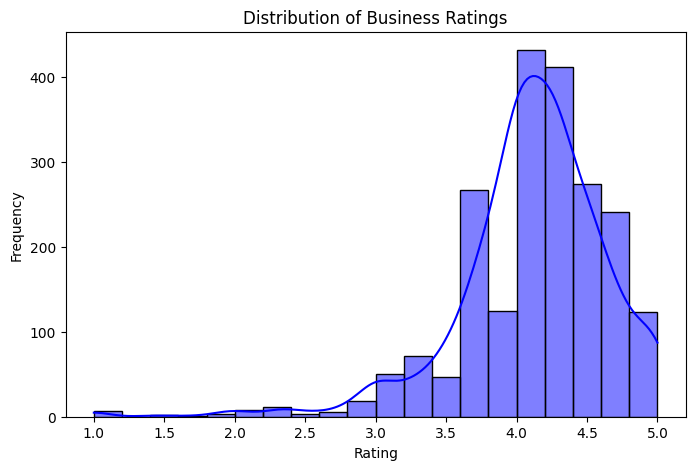

/tmp/ipykernel_14194/3585672799.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='TYPE', order=df['TYPE'].value_counts().index, palette='viridis')


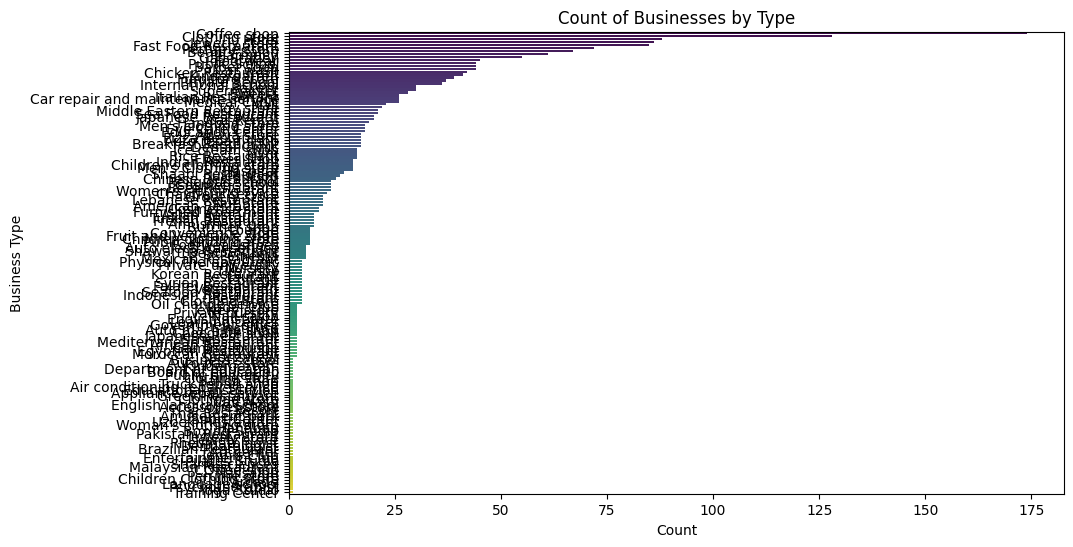

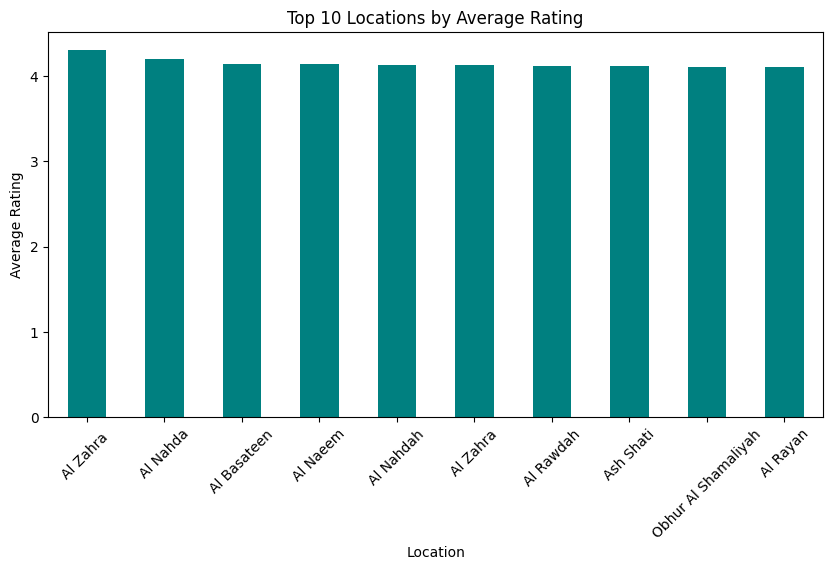

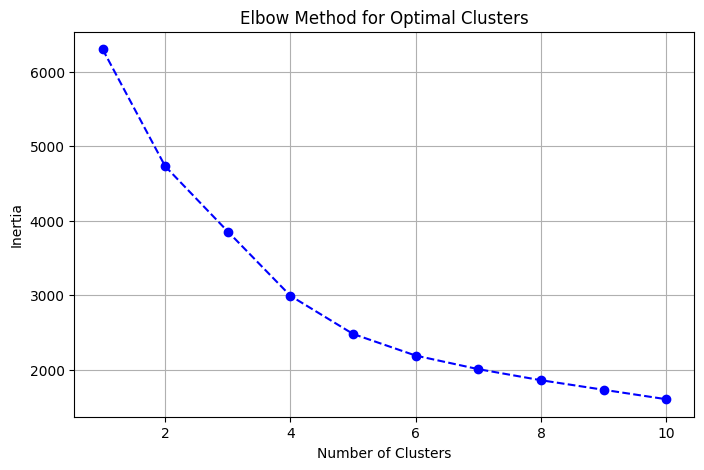

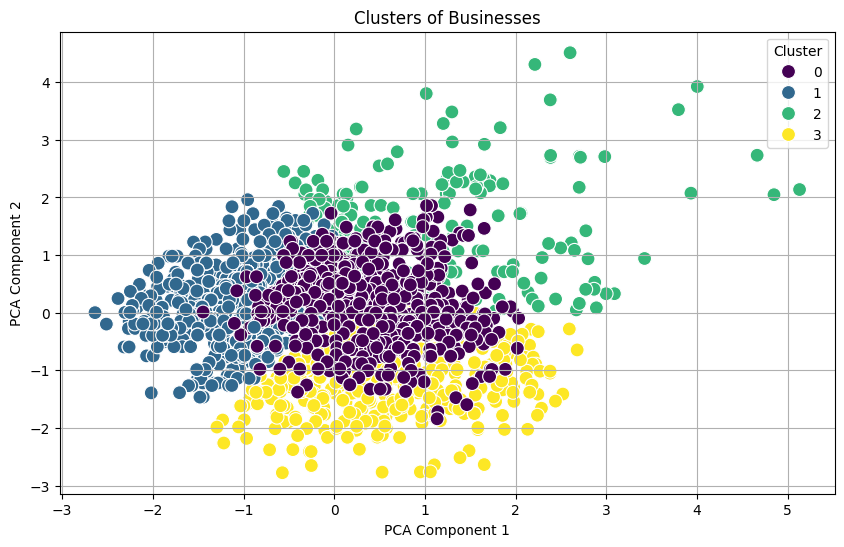


Recommendation for the specific location:
The location 'Al Rawdah' has high competition and a high rating, making it unsuitable for your business.

General recommendations for suitable locations:
Recommended locations for 'Coffee shop':
        LOCATION  RATING
Al Muhammadiyyah     3.0
       Ash Shati     3.0


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Use pickle to export the model
import pickle

# Load the data
file_path = './ROWAD .xlsx'
data = pd.ExcelFile(file_path)
df = data.parse("MERGE DATA")

# Step 1: Data Preprocessing
df['RATING'] = df['RATING'].replace(0, np.nan).astype(float).fillna(df['RATING'].median())
df['LOCATION_encoded'] = df['LOCATION'].astype('category').cat.codes
df['TYPE_encoded'] = df['TYPE'].astype('category').cat.codes

# Step 2: EDA
print("Dataset Overview:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.histplot(df['RATING'], kde=True, bins=20, color='blue')
plt.title("Distribution of Business Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Count of business types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='TYPE', order=df['TYPE'].value_counts().index, palette='viridis')
plt.title("Count of Businesses by Type")
plt.xlabel("Count")
plt.ylabel("Business Type")
plt.show()

# Average rating by location
avg_rating_by_location = df.groupby('LOCATION')['RATING'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
avg_rating_by_location.plot(kind='bar', color='teal')
plt.title("Top 10 Locations by Average Rating")
plt.xlabel("Location")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

# Step 3: Clustering
features = df[['LOCATION_encoded', 'TYPE_encoded', 'RATING']]
features = features.dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow Method for optimal clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Apply K-Means clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
df['PCA1'] = pca_features[:, 0]
df['PCA2'] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=100)
plt.title("Clusters of Businesses")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

# Save the scaler and KMeans model
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

with open('kmeans_model.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

# Step 4: Recommendation System
def analyze_location(location, business_type):
    filtered_data = df[(df['LOCATION'] == location) & (df['TYPE'] == business_type)]
    num_businesses = len(filtered_data)
    avg_rating = filtered_data['RATING'].mean() if not filtered_data.empty else 0
    return num_businesses, avg_rating

def recommend_business(user_location, user_type):
    # Validate user inputs
    if user_location not in df['LOCATION'].values:
        return f"The location '{user_location}' does not exist in the dataset. Please try another location."

    if user_type not in df['TYPE'].values:
        return f"The business type '{user_type}' does not exist in the dataset. Please try another business type."

    # Encode user inputs
    user_location_encoded = df.loc[df['LOCATION'] == user_location, 'LOCATION_encoded'].iloc[0]
    user_type_encoded = df.loc[df['TYPE'] == user_type, 'TYPE_encoded'].iloc[0]

    # Analyze the location
    num_businesses, avg_rating = analyze_location(user_location, user_type)

    # Predict the cluster for user input
    cluster_prediction = kmeans.predict([[user_location_encoded, user_type_encoded, avg_rating]])[0]
    cluster_data = df[df['Cluster'] == cluster_prediction]

    # Apply corrected decision rules
    if num_businesses == 0 and avg_rating <= 3:
        return f"The location '{user_location}' is suitable for your business because it has no competition and a low or average rating."
    elif num_businesses > 0 and avg_rating <= 3:
        return f"The location '{user_location}' has some competition but is suitable. The average rating is {avg_rating}, and there is potential competition."
    elif num_businesses == 0 and avg_rating > 3:
        return f"The location '{user_location}' is highly rated with no competition. However, this may indicate a saturated market. Proceed with caution."
    elif num_businesses > 0 and avg_rating > 3:
        return f"The location '{user_location}' has high competition and a high rating, making it unsuitable for your business."

    # Recommend alternatives within the same cluster
    suitable_locations = cluster_data[(cluster_data['RATING'] <= 3) & (cluster_data['LOCATION'] != user_location)]
    if suitable_locations.empty:
        return "No suitable alternatives found. Consider expanding your search criteria."
    else:
        recommendations = suitable_locations[['LOCATION', 'NAME', 'RATING', 'TYPE']]
        return f"Your location is unsuitable, but we recommend the following alternatives:\n{recommendations.to_string(index=False)}"

def recommend_suitable_locations(business_type):
    # Filter locations with low competition and good ratings
    suitable_data = df[
        (df['TYPE'] == business_type) &  # Filter for the specific business type
        (df['RATING'] <= 3)             # Locations with low or average ratings
    ].sort_values(by=['RATING', 'LOCATION'])  # Sort by rating and location

    # Exclude the user-provided location, if any
    if user_location:
        suitable_data = suitable_data[suitable_data['LOCATION'] != user_location]
        suitable_data = suitable_data.sort_values(by=['RATING', 'LOCATION'])  # Sort by rating and location

    if suitable_data.empty:
        return f"No suitable locations found for business type '{business_type}'."

    # Include location, business name, and rating
    recommendations = suitable_data[['LOCATION', 'RATING']]
    return f"Recommended locations for '{business_type}':\n{recommendations.to_string(index=False)}"

# Step 5: Test the Recommendation System
user_location = input("Enter the location: ")
user_business_type = input("Enter the type of business: ")

# Recommendation for a specific location
specific_result = recommend_business(user_location, user_business_type)
print("\nRecommendation for the specific location:")
print(specific_result)

# Recommendation for suitable locations
print("\nGeneral recommendations for suitable locations:")
general_result = recommend_suitable_locations(user_business_type)
print(general_result)
